In [1]:
!pip install keras-metrics 

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import os

# do random the same everytime
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import load_model
from keras import backend as K
import keras_metrics as km
# import tensorflow as tf

# mount colab
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Load the models and data

In [3]:
# data paths
data_path = r'/content/drive/My Drive/Colab Notebooks/datasets/ProcessedImages'
model_path = r'/content/drive/My Drive/Colab Notebooks/models/classifiers'
models = dict(resize=dict(), segmented=dict())
dnames = ['resized', 'segmented']
datasets = dict(resized=dict(), segmented=dict())
models = dict(resize=dict(), segmented=dict())

# scenario names
scenarios = ['SGD no learning rate reduction',
             'SGD with learning rate reduction',
             'Adam no learning rate reduction',
             'Adam with learning rate reduction']

# numbered scenarios
### Kartik please note that scenarios with an "a" were run successfully with the class weights and are therefore comparable
### Scenarios 3 is legitamate but does not include class weights
### Scenario 4 is dodgy and cannot be used
segmented_scenarios = ['1a', '2a', '3a', '4']
resized_scenarios = ['5a', '6a', '8a', '9a']

# custom model objects - need for loading model
res_obj=dict(binary_recall=km.binary_recall(), binary_precision=km.binary_precision())
seg_obj=dict(binary_recall=km.binary_recall(), binary_precision=km.binary_precision())

# read the datasets
arrnms = ['Xtest', 'Ytest']
# load in the scenarios
for nm in arrnms:
    datasets['resized'][nm] = np.load(os.path.join(data_path, 'resized_' + nm + '.npy'))
    datasets['segmented'][nm] = np.load(os.path.join(data_path, 'segmented_' + nm + '.npy'))
    
    print('Resized data: {} {}\n'.format(nm, datasets['resized'][nm].shape))
    print('Segmented data: {} {}\n'.format(nm, datasets['segmented'][nm].shape))
                                   
for res, seg in zip(resized_scenarios, segmented_scenarios):
    # load in the scenarios
    for nm in arrnms:
        models['resize'][res]=load_model(os.path.join(model_path,
                                                      'resize_classifier_{}.h5'.format(res)), custom_objects=res_obj)
        models['segmented'][seg]=load_model(os.path.join(model_path,
                                                         'segmented_classifier_{}.h5'.format(seg)), custom_objects=seg_obj)

Instructions for updating:
Colocations handled automatically by placer.
Resized data: Xtest (2003, 128, 128, 3)

Segmented data: Xtest (2003, 128, 128, 3)

Resized data: Ytest (2003,)

Segmented data: Ytest (2003,)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
# Predict the values from the validation dataset
sigmoids = dict(resized=dict(), segmented=dict())
for res, seg in zip(resized_scenarios, segmented_scenarios):
    # get the sigmoids
    sigmoids['resized'][res] = models['resize'][res].predict(datasets['resized']['Xtest'])[:, 0]
    sigmoids['segmented'][seg] = models['segmented'][seg].predict(datasets['segmented']['Xtest'])[:, 0]

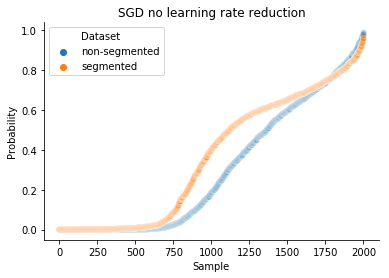

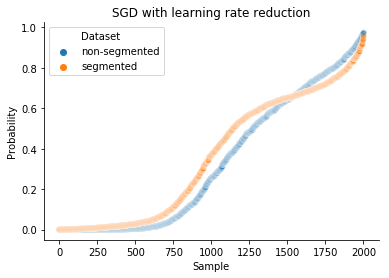

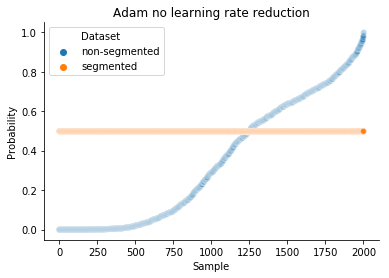

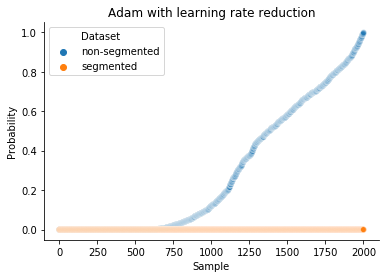

In [5]:
# plot the sigmoid curves
for res, seg, scn in zip(resized_scenarios, segmented_scenarios, scenarios):
    fig, axis = plt.subplots()
    to_plot = pd.DataFrame(np.array([np.sort(sigmoids['resized'][res]),
                                     np.sort(sigmoids['segmented'][seg])]).transpose(),
                           columns=['non-segmented', 'segmented']).reset_index()
    to_plot = pd.melt(to_plot, id_vars='index',
                     value_vars=['non-segmented', 'segmented'],
                     var_name=['Dataset'],
                     value_name='probability')
    sns.scatterplot(x='index', y='probability', 
                    hue='Dataset', alpha=0.3, data=to_plot)
    
    sns.despine()
    plt.title(scn)
    plt.xlabel('Sample')
    plt.ylabel('Probability')    

SGD no learning rate reduction
  - AUC: non-segmented: 0.86, segmented: 0.83
  - Sensitivity: non-segmented: 83.3%, segmented: 89.4%
  - Specificity: non-segmented: 74.4%, segmented: 61.3%
  - Precision: non-segmented: 28.3%, segmented: 21.8%

SGD with learning rate reduction
  - AUC: non-segmented: 0.86, segmented: 0.83
  - Sensitivity: non-segmented: 91.2%, segmented: 88.9%
  - Specificity: non-segmented: 70.2%, segmented: 62.6%
  - Precision: non-segmented: 27.0%, segmented: 22.3%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


Adam no learning rate reduction
  - AUC: non-segmented: 0.87, segmented: 0.00
  - Sensitivity: non-segmented: 88.9%, segmented: 0.0%
  - Specificity: non-segmented: 68.7%, segmented: 100.0%
  - Precision: non-segmented: 25.5%, segmented: nan%

Adam with learning rate reduction
  - AUC: non-segmented: 0.86, segmented: 0.00
  - Sensitivity: non-segmented: 84.7%, segmented: 0.0%
  - Specificity: non-segmented: 75.5%, segmented: 100.0%
  - Precision: non-segmented: 29.5%, segmented: nan%



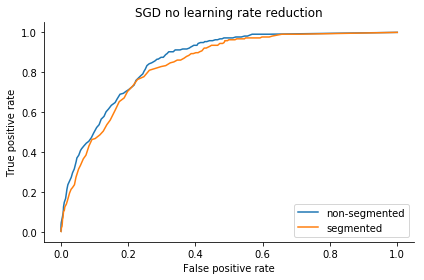

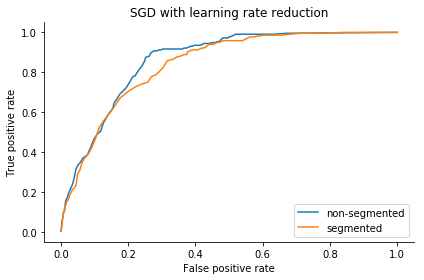

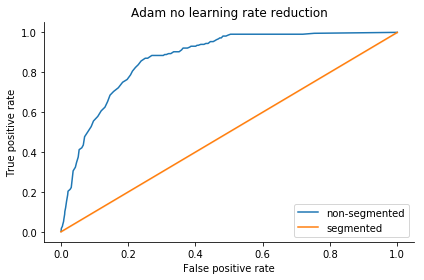

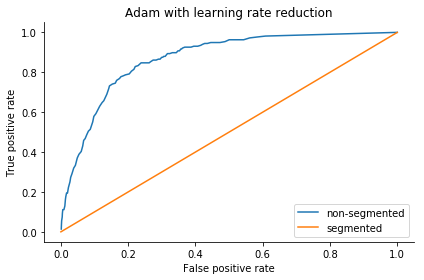

In [6]:
def false_posrate(true, pred):
    # create arrays
    fls_pos = np.zeros(true.shape)
    tru_neg = np.zeros(true.shape)
    
#     print(true.shape, pred.shape)
    
    # checks and store
    fls_pos[(true==0) & (pred==1)] = 1
    tru_neg[(true==0) & (pred==0)] = 1
    
    # false positive rate
    FP = np.sum(fls_pos)
    TN = np.sum(tru_neg)
    
    return FP/(FP+TN)

def true_posrate(true, pred):
    '''
    this is true positive rate also recall or sensitivity
    '''
    
    # create arrays
    tru_pos = np.zeros(true.shape)
    fls_neg = np.zeros(true.shape)

    # checks and store
    tru_pos[(true==1) & (pred==1)] = 1
    fls_neg[(true==1) & (pred==0)] = 1
    
    # false positive rate
    TP = np.sum(tru_pos)
    FN = np.sum(fls_neg)
    
    return TP/(TP+FN)

def precision(true, pred):
    '''
    This is the true positives over the predicted positive values"
    '''
    
    # create arrays
    tru_pos = np.zeros(true.shape)
    fls_neg = np.zeros(true.shape)

    # checks and store
    tru_pos[(true==1) & (pred==1)] = 1
    
    # false positive rate
    TP = np.sum(tru_pos)
    pred_pos = np.sum(pred)
    
    return TP/(pred_pos)

def true_negrate(true, pred):
    '''
    this is true negative rate also specificity
    '''
    
    # create arrays
    tru_neg = np.zeros(true.shape)
    neg = np.zeros(true.shape)

    # checks and store
    tru_neg[(true==0) & (pred==0)] = 1
    neg[true==0] = 1 
    
    # true negative rate
    TN = np.sum(tru_neg)
    N = np.sum(neg)
    
    return TN/(N)

def plot_roc(true, sigmoid, ax):
    points = []
    auc = 0.0
    for threshold in np.arange(0.0, 1.0, 0.01):
        # get predictions pased on threshold
         
        pred = np.zeros(sigmoid.shape)
        pred[sigmoid >= threshold] = 1
    
        # create arrays
        FPR = false_posrate(true, pred)
        TPR = true_posrate(true, pred)

        # calc the auc contribution
        if len(points) > 0:
            deltaFPR = np.sqrt((points[-1][0]-FPR)**2)
            auc += deltaFPR * float(TPR)
        
        # add the point to the list
        points.append([FPR, TPR])

    # return as a datafrom
    roc = pd.DataFrame(points, columns=['FPR', 'TPR'])
    line = sns.lineplot(x='FPR', y='TPR', data=roc, ax=ax) 
    return auc

# roc curves, auc, sensitivity (recall), specificity and precision
for res, seg, scn in zip(resized_scenarios, segmented_scenarios, scenarios):
    fig, ax = plt.subplots()
    
    # calculate the sensitivity, precision and specificity for the non-segmented data
    threshold = 0.5 # <=== changing this changes the sensitivity, precision and specificity 
    true = datasets['resized']['Ytest']
    res_sigmoid = sigmoids['resized'][res]
    res_pred = np.zeros(res_sigmoid.shape)
    res_pred[res_sigmoid >= threshold] = 1
    
    # sensitivity
    res_sens = true_posrate(true, res_pred)
    
    # specificity
    res_spec = true_negrate(true, res_pred)
    
    # precision
    res_prec = precision(true, res_pred)
    
    # calculate the sensitivity, precision and specificity for the non-segmented data
    seg_sigmoid = sigmoids['segmented'][seg]
    seg_pred = np.zeros(seg_sigmoid.shape)
    seg_pred[seg_sigmoid >= threshold] = 1
    
    # sensitivity
    seg_sens = true_posrate(true, seg_pred)
    
    # specificity
    seg_spec = true_negrate(true, seg_pred)
    
    # precision
    seg_prec = precision(true, seg_pred)   
    
    res_auc = plot_roc(true, res_sigmoid, ax)    
    seg_auc = plot_roc(true, seg_sigmoid, ax)
    sns.despine()
    plt.title(scn)    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend((ax.lines[0], ax.lines[1]), ('non-segmented', 'segmented'), )
    plt.tight_layout()
    plt.savefig(os.path.join(model_path, scn + '.jpg'))
    print(scn)
    print('  - AUC: non-segmented: {:.2f}, segmented: {:.2f}'.format(res_auc, seg_auc))
    print('  - Sensitivity: non-segmented: {:.1%}, segmented: {:.1%}'.format(res_sens, seg_sens))
    print('  - Specificity: non-segmented: {:.1%}, segmented: {:.1%}'.format(res_spec, seg_spec))
    print('  - Precision: non-segmented: {:.1%}, segmented: {:.1%}'.format(res_prec, seg_prec))
    print()

From our results, the non-segmented images seemed to out-perform the segmented images - which suggests that segmentation is removing information from the image the is useful for classification

Taking a look at the results from our best scenario "8a" based on the AUC result, lets see 10 samples that were successfully diagnosed as melanoma and 10 false negatives.

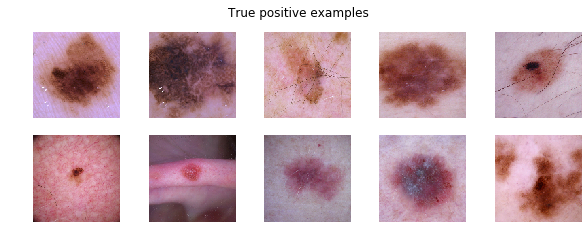

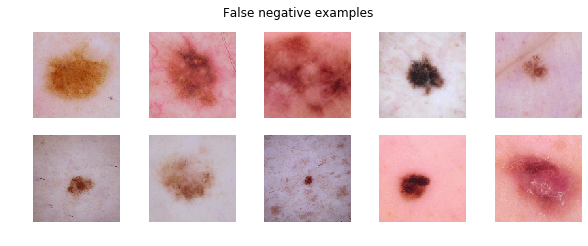

In [7]:
# get results
y_true = datasets['resized']['Ytest']
y_pred = np.zeros(y_true.shape)
y_pred[sigmoids['resized']['8a']>=0.5] = 1

# get true positives
tru_pos = np.where((y_true==1) & (y_pred==1))

# get false negatives
fls_neg = np.where((y_true==1) & (y_pred==0))

# randomly sample 10 from each
tp_sample = np.random.choice(tru_pos[0], 10, replace=False)
fn_sample = np.random.choice(fls_neg[0], 10, replace=False)

# now lets review the images
fig, axis = plt.subplots(2, 5, figsize=(10, 3.5))
ax = axis.flatten()
for idx, axi in zip(tp_sample, range(10)):
    # get the img array
    img = datasets['resized']['Xtest'][idx, :, :, :].copy()
    
    # un-normalise
    unimg = img + 0.5
    
    ax[axi].imshow(unimg)
    ax[axi].set_axis_off()
    
plt.suptitle('True positive examples')
# plt.tight_layout()
plt.savefig(os.path.join(model_path, 'true_pos.jpg' ))

fig, axis = plt.subplots(2, 5, figsize=(10, 3.5))
ax = axis.flatten()
for idx, axi in zip(fn_sample, range(10)):
    # get the img array
    img = datasets['resized']['Xtest'][idx, :, :, :].copy()
    
    # un-normalise
    unimg = img + 0.5
    
    ax[axi].imshow(unimg)
    ax[axi].set_axis_off()
    
_ = plt.suptitle('False negative examples')
# plt.tight_layout()
plt.savefig(os.path.join(model_path, 'false_neg.jpg' ))